# Imports

### Libraries

In [62]:
import time
import pickle
import itertools

import h5py
import numpy as np

import onnx
import pycuda.driver as cuda
import pycuda.autoinit
import tensorrt as trt

from torch import nn
import torch.nn.functional as F

import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

### Path

In [63]:
path_converted_model = "../models/full_model.onnx"
path_dataset = "../datasets/dataset.h5py"
path_labels = "../datasets/labels.pickle"

### Dataset 

In [64]:
with open(path_labels, 'rb') as handle:
    labels = pickle.load(handle)

In [3]:
h5f = h5py.File(path_dataset, 'r')

X_train = np.array(h5f['X_train'])
X_test = np.array(h5f['X_test'])
y_train = np.array(h5f['y_train'])
y_test = np.array(h5f['y_test'])

In [21]:
X_train = X_train.astype(np.float32)
X_test = X_test.astype(np.float32)

In [22]:
def get_batch(array: np.array, size=32):
    for i in range(array.shape[0] // size):
        
        yield array[size*i : size*(i+1)]

### Constants

In [65]:
BATCH_SIZE = 32
OUT_SIZE = len(labels)

# Convert to TensorRT

### Tensor RT engine

In [24]:
TRT_LOGGER = trt.Logger(trt.Logger.VERBOSE)
flags = 1 << (int)(trt.NetworkDefinitionCreationFlag.EXPLICIT_BATCH)

def build_engine(model_path):
    """Build and return the TensorRT engine and context."""
    
    with trt.Builder(TRT_LOGGER) as builder, builder.create_network(flags) as network, trt.OnnxParser(network, TRT_LOGGER) as parser: 
        
        # Set builder 1GB Vram, batch size 1 & fp16 if possible
        builder.max_workspace_size = 1 << 30
        builder.max_batch_size = BATCH_SIZE
        
        if builder.platform_has_fast_fp16:
            builder.fp16_mode = True
        
        # Load ONNX model
        with open(model_path, "rb") as f:
            parser.parse(f.read())
        
        # Generate an engine optimized for the target platform
        engine = builder.build_cuda_engine(network)
        context = engine.create_execution_context()

        return engine, context

### Inference pipeline

This function allocate memory on the CPU and GPU. It has to be called before any inference. Once the memory has been allocated, the data can be passed and an inference can be done.

In [25]:
def allocate_buffer(engine):
    
    # Host CPU memory
    h_in_size = trt.volume(engine.get_binding_shape(0))
    h_out_size = trt.volume(engine.get_binding_shape(1))
    h_in_dtype = trt.nptype(engine.get_binding_dtype(0))
    h_out_dtype = trt.nptype(engine.get_binding_dtype(1))
    
    in_cpu = cuda.pagelocked_empty(h_in_size, h_in_dtype)
    out_cpu = cuda.pagelocked_empty(h_out_size, h_out_dtype)
    
    # Allocate GPU memory
    in_gpu = cuda.mem_alloc(in_cpu.nbytes)
    out_gpu = cuda.mem_alloc(out_cpu.nbytes)
    
    stream = cuda.Stream()
    return in_cpu, out_cpu, in_gpu, out_gpu, stream

This function take allocated space, an input matrix, and run the inference.

In [11]:
def inference(engine, context, inputs, out_cpu, in_gpu, out_gpu, stream):
    
    cuda.memcpy_htod(in_gpu, inputs)
    context.execute(1, [int(in_gpu), int(out_gpu)])
    cuda.memcpy_dtoh(out_cpu, out_gpu)
    
    return out_cpu

# Inference

In [12]:
engine, context = build_engine(path_converted_model)

In [26]:
results = []
t1 = time.time()

for batch in get_batch(X_test, BATCH_SIZE):
    
    in_cpu, out_cpu, in_gpu, out_gpu, stream = allocate_buffer(engine)
    results.append(inference(engine, context, batch.reshape(-1), out_cpu, in_gpu, out_gpu, stream))

cost_time = time.time() - t1

# Output post-processing

Batch inferences flatten all results. We have to get back result as array of 6 for each images.

In [74]:
# Flatten the list
flatten = np.array(list(itertools.chain(*results)))

# Get the amount of predicted values
flatten_lenght = int(flatten.shape[0] / OUT_SIZE)

In [75]:
reshaped = flatten.reshape(flatten_lenght, OUT_SIZE)

# Evaluation

### Inference time

Inference time: **0.3408** sec, for **755** images.

Time per image: **0.004 sec**/image

In [83]:
result_lenght = len(reshaped)
result_lenght

736

In [84]:
print("cost time: ", cost_time)

cost time:  0.14114856719970703


In [85]:
print("time per image: ", cost_time / result_lenght)

time per image:  0.00019177794456481934


### Score

In [86]:
prediction = reshaped.argmax(axis=1)

<AxesSubplot:>

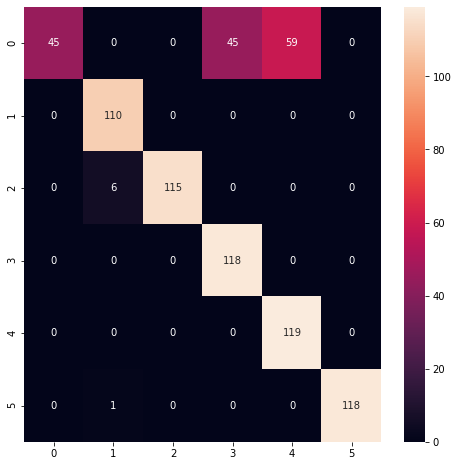

In [87]:
conf_matrix = confusion_matrix(y_test[:result_lenght], prediction)

plt.figure(figsize=(8, 8))
sns.heatmap(conf_matrix, annot=True, fmt='g')